# Tutorial 6 - Deprojecting 1D FEP to 2D FES

## Introduction

In this notebook, we are going to show how one could construct a 2D free energy surface in terms of 2 collective variables Q1 and Q2 from the results of umbrella sampling that was only biased in 1D alond collective variable CV. More specifically, we consider the case study of the formic acid dimer as given in the image below:


<img src="formic_acid_dimer.png" height=300 />

The 1D profile is constructed by means of umbrella sampling using the collective variable :math:`CV=d_1-d_2+d_4-d_3`. Afterwards, we will deproject towards a FES in terms of $Q_1=d_1-d_2$ and $Q_2=d_4-d_3$.

In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
from thermolib.thermodynamics.fep import SimpleFreeEnergyProfile, plot_profiles
from thermolib.thermodynamics.histogram import Histogram1D
from thermolib.tools import read_wham_input, decorrelate
from thermolib.thermodynamics.cv import CoordinationNumber, Difference, LinearCombination
from thermolib.thermodynamics.trajectory import ColVarReader
from thermolib.thermodynamics.condprob import ConditionalProbability1D2D

import numpy as np, matplotlib.pyplot as pp, os

from molmod.units import *

## Construct 1D FEP

We first construct the original 1D FEP by means of a regular WHAM analysis.

In [3]:
fn_meta = 'data/formic_acid_dimer_link/wham_input.txt'
colvar_reader = ColVarReader([0], units=['au'], end=10000)
temp, bias1d, traj1d = read_wham_input(
    fn_meta, colvar_reader, 'colvars/COLVAR_%s.dat', 
    bias_potential='Parabola1D', q01_unit='au', kappa1_unit='kjmol',
)

We compute the correlation time between samples of the CV for each trajectory based on the auto correlation function.

/home/louis/miniconda3/lib/python3.8/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


<Figure size 432x288 with 0 Axes>

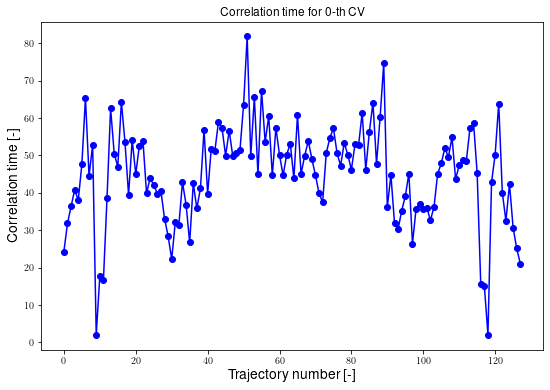

In [4]:
corrtimes_1d = decorrelate(traj1d, plot=True)

Do 1D-WHAM to extract the probability histogram.

In [5]:
bins = np.arange(-1.55, 1.55, 0.05)
hist1d = Histogram1D.from_wham(bins, traj1d, bias1d, temp, error_estimate='mle_f_cov', corrtimes=corrtimes_1d, cv_label='CV', convergence=1e-8, Nscf=20000)

SCF Converged!
---------------------------------------------------------------------
TIMING SUMMARY
  initializing: 00h 00m 00.000s
  histograms  : 00h 00m 00.069s
  bias poten. : 00h 00m 00.006s
  solve scf   : 00h 00m 00.808s
  error est.  : 00h 00m 00.021s
  TOTAL       : 00h 00m 00.906s
---------------------------------------------------------------------


Convert probability histogram to free energy profile. Detect reaction, transition and product states, set the energy reference such that the reactant microstate is at zero energy and plot the results.

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


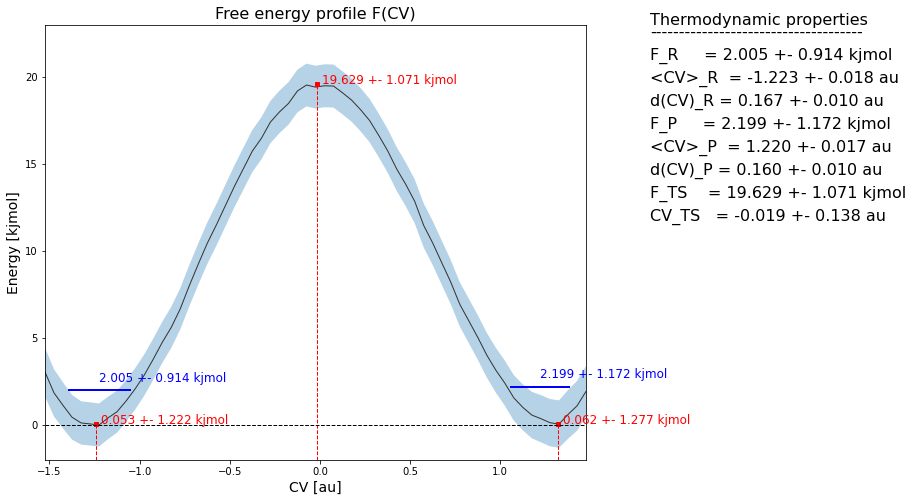

In [6]:
fep = SimpleFreeEnergyProfile.from_histogram(hist1d, temp, cv_output_unit='au', cv_label='CV', f_output_unit='kjmol')
fep.process_states(lims=[-np.inf,-0.2,0.2,np.inf])
fep.set_ref(ref='r')
fep.plot(flims=[-2,23])

## Deproject to 2D FES

Now we deproject the obtained 1D FEP $F_1(CV)$ towards a 2D FES $F_2(Q_1,Q_2)$

In [7]:
#CV definition
d1 = CoordinationNumber([[0,9]], r0=1.4*angstrom)
d2 = CoordinationNumber([[7,9]], r0=1.4*angstrom)
d3 = CoordinationNumber([[2,4]], r0=1.4*angstrom)
d4 = CoordinationNumber([[5,4]], r0=1.4*angstrom)
CV = LinearCombination([d1,d2,d3,d4], [1., -1., -1., 1.])
Q1 = Difference(d2,d1, name='d1-d2')
Q2 = Difference(d3,d4, name='d4-d3')

In [8]:
condprob = ConditionalProbability1D2D(q1_label='d1-d2', q2_label='d4-d3', cv_label='CV')
fns = ['data/formic_acid_dimer_link/colvars/u%i.xyz' %i for i in range(128)]
condprob.process_trajectory_xyz(fns, Q1, Q2, CV)

In [9]:
cv_bins = np.arange(-1.55, 1.55, 0.05)
q_bins = [np.arange(-1.0, 1.05, 0.05), np.arange(-1.0, 1.05, 0.05)]
#condprob._finished = False
condprob.finish(q_bins, cv_bins)

In [10]:
fes = condprob.deproject(fep)
fes.set_ref(ref='min')

/home/louis/miniconda3/lib/python3.8/site-packages/thermolib/thermodynamics/fep.py:2157: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cbar = pp.colorbar(contourf, ax=ax, extend='both')


<Figure size 432x288 with 0 Axes>

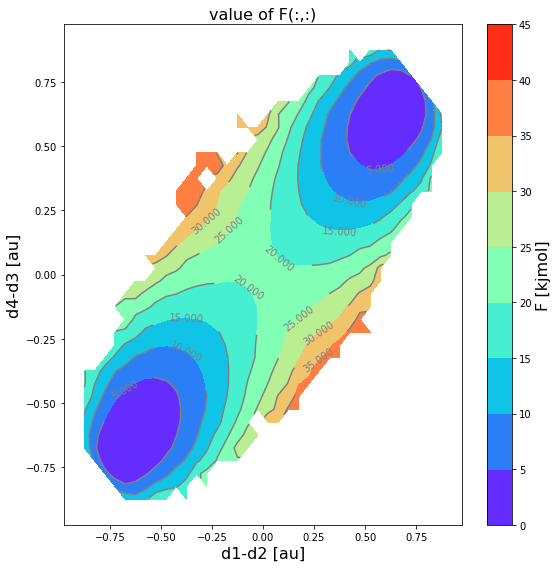

In [11]:
fes.plot(cmap='rainbow', flims=[0,45],ncolors=9)